In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
def snake_case(texto):
  "Transforma um texto em padrão snake. Exemplo: 'Olá Pessoal' > 'ola_pessoal'"
  return texto.strip().lower().replace(' ', '_')

In [ ]:
def teste_hipotese(df, parametro_1, parametro_2):
  cumpre_parametro_1 = df[df[parametro_1] == 1][parametro_2]
  nao_cumpre_parametro_1 = df[df[parametro_1] == 0][parametro_2]
  t, p_value = stats.ttest_ind(cumpre_parametro_1, nao_cumpre_parametro_1)
  print(t)
  print(p_value)

In [ ]:
df = pd.read_csv('retail_case_data.csv')

In [ ]:
df.columns = [snake_case(coluna) for coluna in df.columns]

In [ ]:
df.head()

,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,...,numwebvisitsmonth,acceptedcmp3,acceptedcmp4,acceptedcmp5,acceptedcmp1,acceptedcmp2,complain,z_costcontact,z_revenue,response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [ ]:
# Inicialmente vamos realizar os tratamentos de qualidade dos dados, sendo eles:
# - Tratamento de campos nulos.
# - Tratamento de outliers.

In [ ]:
# df.isnull().sum()

In [ ]:
# Por serem apenas 24 valores em um universo de mais de 2000 casos, vou excluir os casos com campos vazios.

In [ ]:
df = df.dropna(subset='income')

In [ ]:
# Observando o DataFrame percebemos que podemos realizar mais alguns tratamentos importantes para posteriormente avaliarmos os dados.
# Como exemplo, tratar as variáveis categóricas utilizando codificação binária para representar as características (dummy variables), úteis para considerar as informações qualitativas.
# No caso da escolaridade vamos fazer uma tratativa de codificação ordinal, já que há uma sequência esperada de realização.
# Gosto também pessoalmente de tratar datas para variáveis contínuas positivas (deltas).

In [ ]:
df.dt_customer = pd.to_datetime(df.dt_customer)

In [ ]:
df['data_de_analise'] = pd.to_datetime(datetime.today())

In [ ]:
df['tempo_decorrido_cadastro'] = (df['data_de_analise'] - df['dt_customer']).dt.days
df['idade'] = df.data_de_analise.dt.year - df.year_birth
df = df.drop('data_de_analise', axis=1)
df = df.drop('dt_customer', axis=1)

In [ ]:
df_encoded = pd.get_dummies(df, columns=['marital_status'])

In [ ]:
ordem_categorias = {'Basic':1, 'Graduation':2, '2n Cycle':3, 'Master':3, 'PhD':4}
# Considerei que o 2n cycle é o referente ao segundo ciclo europeu (mestrado).

In [ ]:
df_encoded['education'] = df_encoded['education'].map(ordem_categorias)

In [ ]:
df_encoded.columns = [snake_case(coluna) for coluna in df_encoded.columns]

In [ ]:
# Aproveitando que removemos as variáveis categóricas, vamos também limpar a base dos outliers, utilizando 3 desvios padrão.

In [ ]:
continuous_columns = ['income', 'kidhome', 'teenhome', 'recency',
       'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts',
       'mntsweetproducts', 'mntgoldprods', 'numdealspurchases',
       'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases',
       'numwebvisitsmonth', 'tempo_decorrido_cadastro', 'idade']

In [ ]:
df_filtered = df_encoded[continuous_columns]

In [ ]:
z_scores = stats.zscore(df_filtered)
threshold = 3

In [ ]:
df_filtered = df_filtered[(z_scores < threshold).all(axis=1)]

In [ ]:
df_encoded = df_encoded.loc[df_filtered.index]

In [ ]:
# Neste momento iniciei a análise de correlação, as questões exigiram a avaliação de poucos parâmetros, são eles:
# 1. idade do clientes vs conversão
# 2. escolaridade vs conversão
# 3. renda vs conversão
# Parâmetro considerado:
# correl forte: +1 a +.7 ou -.7 a -1
# correl moderada: +.7 a +.3 ou -.3 a -.7
# correl fraca: +.3 a 0 ou 0 a -.3

In [ ]:
correl = df_encoded.corr()

In [ ]:
correl['idade']['response'] # Correlação fraca

-0.003117884173573325

In [ ]:
# Para duplamente validar a não correlação, vamos realizar um teste de hipótese:
# H0: A média de idade dos clientes que compraram o produto é igual dos que não compraram.
# H1: A média de idades dos clientes que compraram o produto é diferente dos que não compraram.

In [ ]:
teste_hipotese(df_encoded, 'response', 'idade')

-0.13771800510499396
0.890477500043385


In [ ]:
# Como normalmente o nível de significância escolhido é de 0.05, consideramos que NÃO podemos rejeitar a hipótese nula.

In [ ]:
print(correl['education']['response']) # Correlação fraca

0.1069305808245222


In [ ]:
# Para duplamente validar a não correlação, vamos realizar um teste de hipótese:
# H0: A média de educação formal dos clientes que compraram o produto é igual dos que não compraram.
# H1: A média de educação formal dos clientes que compraram o produto é diferente dos que não compraram.

In [ ]:
teste_hipotese(df_encoded, 'response', 'education')

4.7503735103290525
2.1785251328868787e-06


In [ ]:
# Como normalmente o nível de significância escolhido é de 0.05, consideramos que PODEMOS rejeitar a hipótese nula.
# Mesmo com a correlação sendo inconclusiva em primeiro momento, afirmamos que a educação dos clientes interfere sim na compra do produto de acordo com o teste de hipótese.

In [ ]:
correl['income']['response'] # Correlação fraca

0.12403633653939328

In [ ]:
# Para duplamente validar a não correlação, vamos realizar um teste de hipótese:
# H0: A média de renda dos clientes que compraram o produto é igual dos que não compraram.
# H1: A média de renda dos clientes que compraram o produto é diferente dos que não compraram.

In [ ]:
teste_hipotese(df_encoded, 'response', 'income')

5.521338129562282
3.8141722328771546e-08


In [ ]:
# Como normalmente o nível de significância escolhido é de 0.05, consideramos que PODEMOS rejeitar a hipótese nula.
# Mesmo com a correlação sendo inconclusiva em primeiro momento, afirmamos que a renda dos clientes interfere sim na compra do produto de acordo com o teste de hipótese.

In [ ]:
# Vamos plotar os gráficos de regressão para melhor visualizar as três variáveis.

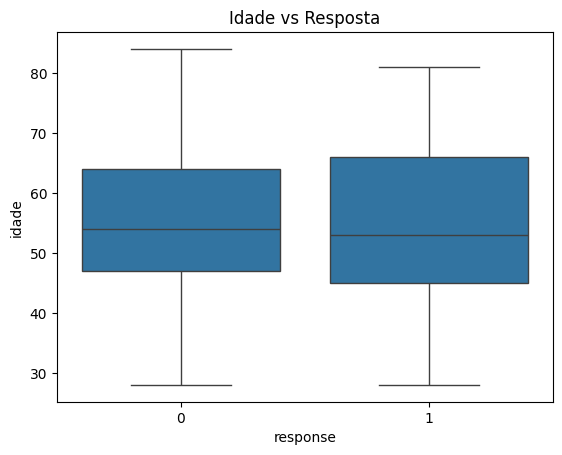

In [ ]:
# idade vs response
x = df_encoded.idade
y = df_encoded.response
sns.boxplot(x='response', y='idade', data=df_encoded)
plt.title('Idade vs Resposta')
plt.show()

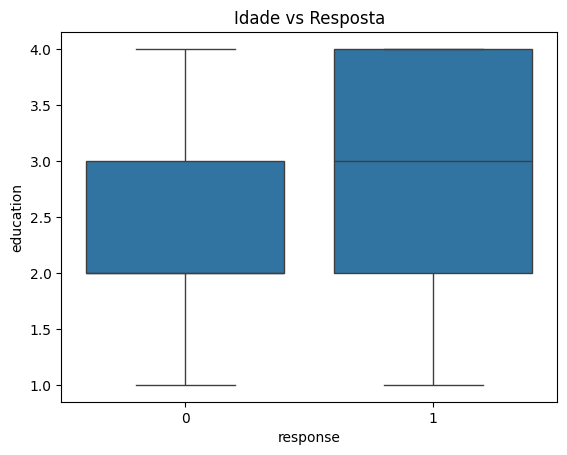

In [ ]:
# education vs response
x = df_encoded.idade
y = df_encoded.response
sns.boxplot(x='response', y='education', data=df_encoded)
plt.title('Educação formal vs Resposta')
plt.show()

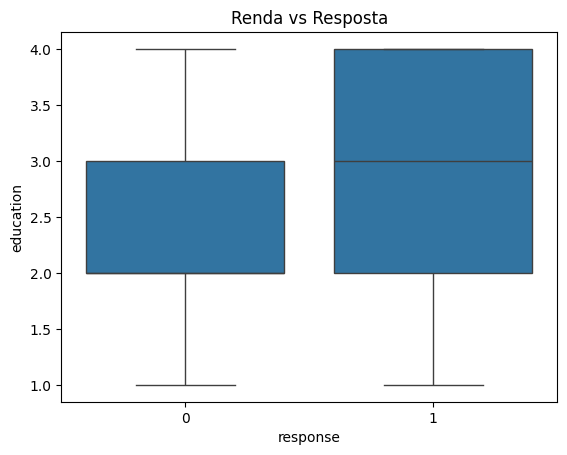

In [ ]:
# renda vs response
x = df_encoded.idade
y = df_encoded.response
sns.boxplot(x='response', y='education', data=df_encoded)
plt.title('Renda vs Resposta')
plt.show()

In [ ]:
correl['response'].sort_values()

recency                    -0.185385
teenhome                   -0.138097
marital_status_married     -0.075823
marital_status_together    -0.062620
kidhome                    -0.060095
marital_status_absurd      -0.008890
id                         -0.008833
idade                      -0.003118
year_birth                  0.003118
complain                    0.004890
numstorepurchases           0.020414
numdealspurchases           0.022713
marital_status_alone        0.023019
marital_status_yolo         0.034473
marital_status_widow        0.040463
numwebvisitsmonth           0.044911
marital_status_divorced     0.045641
mntfruits                   0.092032
marital_status_single       0.102287
education                   0.106931
mntfishproducts             0.107144
income                      0.124036
mntsweetproducts            0.125121
acceptedcmp2                0.138460
acceptedcmp4                0.148799
mntgoldprods                0.151539
numwebpurchases             0.152846
m

In [ ]:
# Chamam atenção as seguintes correlações (>0.1 ou <-0.1):
#
# Positivas:
# 1. Clientes que aceitaram uma das 5 últimas campanhas, com destaque às campanhas 1, 3 e 5.
# 2. Gastos em vinhos, carnes, ouro, frutas e peixes, em ordem decrescente de importância.
# 3. Volume de compras por catálogo e web.
# 4. Tempo decorrido do cadastro.
# 5. Renda.
# 6. Pessoas solteiras.
#
# Negativas:
# 1. Tempo desde a última compra.
# 2. Clientes com jovens.
#
# Sendo assim vamos olhar as estatísticas destas variáveis para os casos em que a campanha converteu.

In [ ]:
df_filtered = df_encoded[df_encoded.response == 1]

In [ ]:
describe = df_filtered.describe()

In [ ]:
colunas_interesse = ['acceptedcmp1',
                     'acceptedcmp5',
                     'acceptedcmp3',
                     'acceptedcmp4',
                     'acceptedcmp2',
                     'mntwines',
                     'mntmeatproducts',
                     'numcatalogpurchases',
                     'numwebpurchases',
                     'mntgoldprods',
                     'mntsweetproducts',
                     'mntfishproducts',
                     'education',
                     'income',
                     'recency',
                     'tempo_decorrido_cadastro',
                     'teenhome']

In [ ]:
correl_var = df_encoded[colunas_interesse].corr().abs() > 0.7

In [ ]:
correl_var

,acceptedcmp1,acceptedcmp5,acceptedcmp3,acceptedcmp4,acceptedcmp2,mntwines,mntmeatproducts,numcatalogpurchases,numwebpurchases,mntgoldprods,mntsweetproducts,mntfishproducts,education,income,recency,tempo_decorrido_cadastro,teenhome
acceptedcmp1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
acceptedcmp5,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
acceptedcmp3,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
acceptedcmp4,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
acceptedcmp2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
mntwines,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False
mntmeatproducts,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False
numcatalogpurchases,False,False,False,False,False,True,True,True,False,False,False,False,False,True,False,False,False
numwebpurchases,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
mntgoldprods,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [ ]:
# Reavaliando a correlação percebemos conexão com algumas variáveis.
# Exemplo: Renda, compra de vinho, carnes e compras por catálogo estão fortemente correlacionados entre si, sendo assim, não seremos redundantes, nos atendo a variável renda.

In [ ]:
colunas_usadas = ['numwebpurchases','income', 'tempo_decorrido_cadastro', 'recency', 'acceptedcmp1','acceptedcmp5','acceptedcmp3','acceptedcmp4','acceptedcmp2','response']

In [ ]:
# Vou usar as médias e os desvios padrão para determinar valores aceitáveis para as variáveis utilizadas.

In [ ]:
threshold = .5
for coluna in colunas_usadas:
  print(f"{coluna}:\nMínimo: {describe[coluna]['mean'] - threshold * describe[coluna]['std']}\nMédia: {describe[coluna]['mean']}\nMáximo: {describe[coluna]['mean'] + threshold * describe[coluna]['std']}\n\n")

numwebpurchases:
Mínimo: 3.5791274889554607
Média: 4.931034482758621
Máximo: 6.282941476561781


income:
Mínimo: 43982.20142758434
Média: 55366.528735632186
Máximo: 66750.85604368003


tempo_decorrido_cadastro:
Mínimo: 3939.7144146118267
Média: 4038.647509578544
Máximo: 4137.580604545261


recency:
Mínimo: 21.341241133432742
Média: 35.47892720306513
Máximo: 49.61661327269752


acceptedcmp1:
Mínimo: -0.010168697847097147
Média: 0.1839080459770115
Máximo: 0.37798478980112016


acceptedcmp5:
Mínimo: 0.00890687401489032
Média: 0.21455938697318008
Máximo: 0.42021189993146985


acceptedcmp3:
Mínimo: 0.03239758438730922
Média: 0.24904214559386972
Máximo: 0.46568670680043023


acceptedcmp4:
Mínimo: -0.018968580363558446
Média: 0.1685823754789272
Máximo: 0.3561333313214129


acceptedcmp2:
Mínimo: -0.059175031259465695
Média: 0.04980842911877394
Máximo: 0.1587918894970136


response:
Mínimo: 1.0
Média: 1.0
Máximo: 1.0




In [ ]:
# Condições determinadas:
# Realizou uma compra em uma das 3 campanhas foco
# E renda superior a 45000MU
# ou mais que três compras realizadas pela web
# ou última compra a menos que 50 dias
# ou cadastro realizado a pelo menos 4000 dias

In [ ]:
filter_reimpact = ((df_encoded.acceptedcmp1 == 1) |
(df_encoded.acceptedcmp3 == 1) |
(df_encoded.acceptedcmp5 == 1))
df_teste = df_encoded[filter_reimpact]
len(df_teste)

275

In [ ]:
# 18% da amostra coletada já foi atingida por uma campanha e convertida.
# 14% da amostra coletada já foi atingida pela campanha 1, 5 ou 3 e convertida, campanhas que tem grande correlação com a campanha atual.
# Sendo o break-even em 27% e o lucro mínimo de 11% (definido pela taxa básica), usarei uma estratégia de reimpacto nas campanhas 1, 3 e 5.
# Em adicional colocarei condições restritivas de renda e tempo de cadastro ou última compra ou compras web para diminuir nossa faixa e aumentar a provável conversão.
# Com essas alterações ainda fico com alcance de quase 10% da base.
# Levando em conta que se trata de uma base de centenas de milhares de clientes, acredito conseguir atingir uma base de pelo menos 10x o tamanho do piloto.

In [ ]:
filtro = (
((df_encoded.income > 45000) & (
(df_encoded.tempo_decorrido_cadastro > 4000) |
(df_encoded.recency < 50) |
(df_encoded.numwebpurchases > 3))) & (
((df_encoded.acceptedcmp1 == 1) |
(df_encoded.acceptedcmp3 == 1) |
(df_encoded.acceptedcmp5 == 1))
)
)


In [ ]:
df_old = df_encoded[colunas_usadas]
df_new = df_encoded[colunas_usadas]
df_new = df_new[filtro]
print(len(df_new)/len(df_old))

0.09779825908858167


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
scaler = StandardScaler()
X = df_encoded.drop('response', axis=1)
y = df_encoded.response
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
modelo_antigo = LogisticRegression()
modelo_antigo.fit(X_train, y_train)
previsoes = modelo_antigo.predict(X_test)
print(accuracy_score(y_test, previsoes))
print(confusion_matrix(y_test,previsoes))
probabilidades_previstas = modelo_antigo.predict_proba(X)[:, 1]
taxa_conversao_prevista = (probabilidades_previstas > 0.5).mean() * 100

0.8996929375639714
[[830  18]
 [ 80  49]]


In [ ]:
scaler = StandardScaler()
X = df_new.drop('response', axis=1)
y = df_new.response
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_novo = LogisticRegression()
modelo_novo.fit(X_train, y_train)
previsoes = modelo_novo.predict(X_test)
print(accuracy_score(y_test, previsoes))
print(confusion_matrix(y_test,previsoes))
probabilidades_previstas = modelo_novo.predict_proba(X)[:, 1]
taxa_conversao_prevista = (probabilidades_previstas > 0.5).mean() * 100

0.717948717948718
[[16  4]
 [ 7 12]]


In [ ]:
taxa_conversao = (np.sum(previsoes)/len(previsoes))*100
print(taxa_conversao)
print(taxa_conversao_prevista)

41.02564102564102
46.596858638743456


In [ ]:
taxa_conversao = (np.sum(df_encoded.response)/len(df_encoded.response))*100
print(taxa_conversao)

13.36405529953917


In [ ]:
# Aumento da conversão de 13.36% da base limpa para 41.02% com confiabilidade de quase 72% (ainda baixa)